In [1]:
from datasets import load_dataset
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import layers, models, callbacks
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

print("✅ Entorno limpio y funcionando")

✅ Entorno limpio y funcionando


In [ ]:
tf.config.list_physical_devices('GPU')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/721 [00:00<?, ?B/s]

data/train-00000-of-00004.parquet:   0%|          | 0.00/418M [00:00<?, ?B/s]

data/train-00001-of-00004.parquet:   0%|          | 0.00/408M [00:00<?, ?B/s]

data/train-00002-of-00004.parquet:   0%|          | 0.00/385M [00:00<?, ?B/s]

data/train-00003-of-00004.parquet:   0%|          | 0.00/406M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/323M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Etiqueta: 0 | Imagen shape: (256, 256, 3)


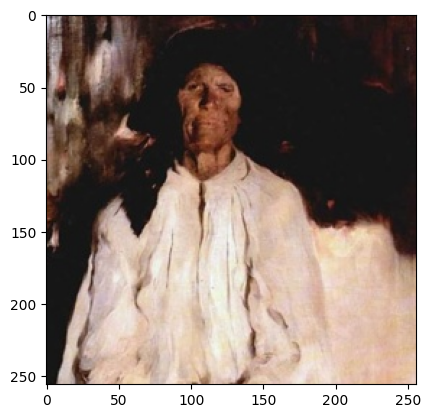

In [2]:
#Se carga el dataset desde HuggingFace
dataset = load_dataset("zguo0525/ArtBench")

#Se obtienen las divisiones
train_ds = dataset["train"]
test_ds = dataset["test"]

#Ejemplo
ej = train_ds[100]
img_array = np.array(ej["image"])
print("Etiqueta:", ej["label"], "| Imagen shape:", img_array.shape)
plt.imshow(img_array)
plt.show()

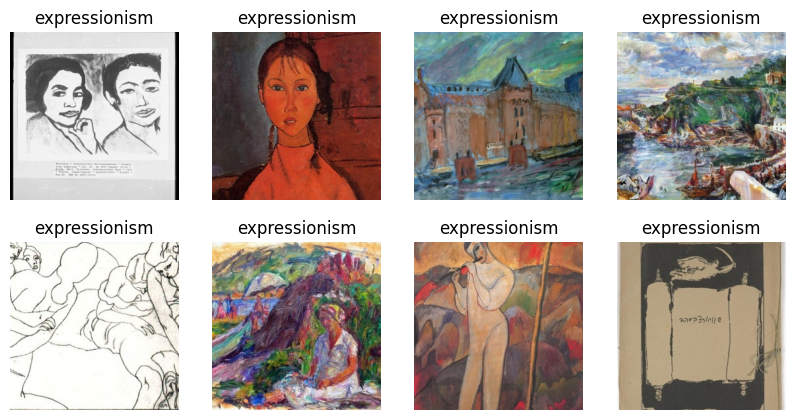

In [3]:
#Muestras del dataset

#Primero se hace el mapeo de labels.
class_names = train_ds.features["label"].names

fig, axes = plt.subplots(2, 4, figsize=(10,5))
for i, (example) in enumerate(dataset["train"].select(range(8))):
    img = example["image"]
    axes[i//4, i%4].imshow(img)
    axes[i//4, i%4].set_title(f"{class_names[example['label']]}")
    axes[i//4, i%4].axis("off")
plt.show()

In [4]:
IMG_SIZE = 224

#Se redimensionan a 224x224 y se normalizan [0,1]
def preprocess_tf(example):
    #Se realiza la siguiente conversión: PIL -> NumPy -> Tensor
    image = np.array(example["image"])
    image = tf.convert_to_tensor(image)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE)) #Redimensión
    image = tf.cast(image, tf.float32) / 255.0   # normalización [0,1]
    label = example["label"]
    return {"image": image, "label": label}

#Se aplica una transformación eficiente sin cargar todo a memoria
#Para que colab no explote c:
train_tf = dataset["train"].with_transform(preprocess_tf)
test_tf  = dataset["test"].with_transform(preprocess_tf)

#Se crean los nuevos datasets para Keras
tf_train = train_tf.to_tf_dataset(
    columns="image",
    label_cols="label",
    batch_size=64,
    shuffle=True
)

tf_test = test_tf.to_tf_dataset(
    columns="image",
    label_cols="label",
    batch_size=64
)

In [5]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models, optimizers

base_model = InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base_model.trainable = False

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = models.Model(inputs, outputs)

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    tf_train,
    validation_data=tf_test,
    epochs=5
)

base_model.trainable = True
for layer in base_model.layers[:200]:  # congela parte del backbone
    layer.trainable = False

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    tf_train,
    validation_data=tf_test,
    epochs=10
)


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 337s 404ms/step - accuracy: 0.3079 - loss: 2.0452 - val_accuracy: 0.4447 - val_loss: 1.5431
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 291s 372ms/step - accuracy: 0.4243 - loss: 1.6160 - val_accuracy: 0.4725 - val_loss: 1.4752
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 304s 388ms/step - accuracy: 0.4306 - loss: 1.5939 - val_accuracy: 0.4714 - val_loss: 1.4738
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 306s 391ms/step - accuracy: 0.4378 - loss: 1.5792 - val_accuracy: 0.4679 - val_loss: 1.5052
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 307s 393ms/step - accuracy: 0.4432 - loss: 1.5684 - val_accuracy: 0.4622 - val_loss: 1.5181
Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 415s 487ms/step - accuracy: 0.4358 - loss: 1.5512 - val_accuracy: 0.5252 - val_loss: 1.3119
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 361s 461ms/step - accuracy: 0.5503 - loss: 1.2309 - val_accuracy: 0.5487 - val_loss: 1.2424
Epoch 3/10
782/782 ━━━━━━━━━━━

In [17]:
class_names = dataset["train"].features["label"].names
print(class_names)

['expressionism', 'art_nouveau', 'renaissance', 'ukiyo_e', 'realism', 'romanticism', 'surrealism', 'impressionism', 'baroque', 'post_impressionism']


                    precision    recall  f1-score   support

     expressionism      0.451     0.443     0.447      1000
       art_nouveau      0.524     0.529     0.527      1000
       renaissance      0.661     0.648     0.654      1000
           ukiyo_e      0.927     0.928     0.928      1000
           realism      0.361     0.416     0.386      1000
       romanticism      0.455     0.432     0.443      1000
        surrealism      0.699     0.704     0.702      1000
     impressionism      0.428     0.406     0.417      1000
           baroque      0.614     0.650     0.631      1000
post_impressionism      0.454     0.413     0.432      1000

          accuracy                          0.557     10000
         macro avg      0.557     0.557     0.557     10000
      weighted avg      0.557     0.557     0.557     10000



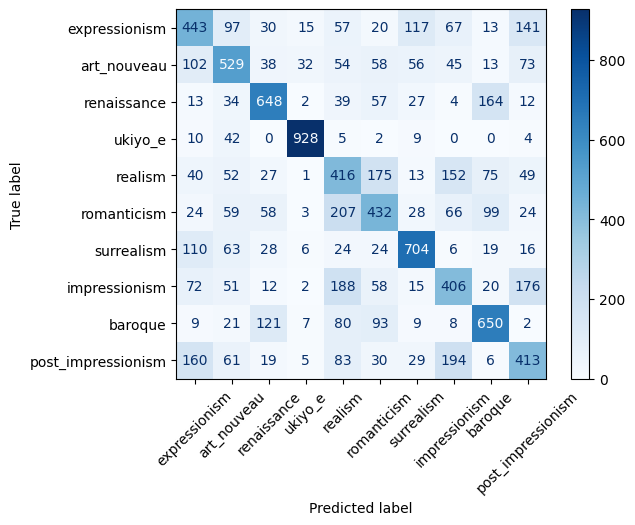

In [18]:
y_true, y_pred = [], []

for images, labels in tf_test:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred, target_names=class_names, digits=3))
ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=class_names).plot(xticks_rotation=45, cmap="Blues")

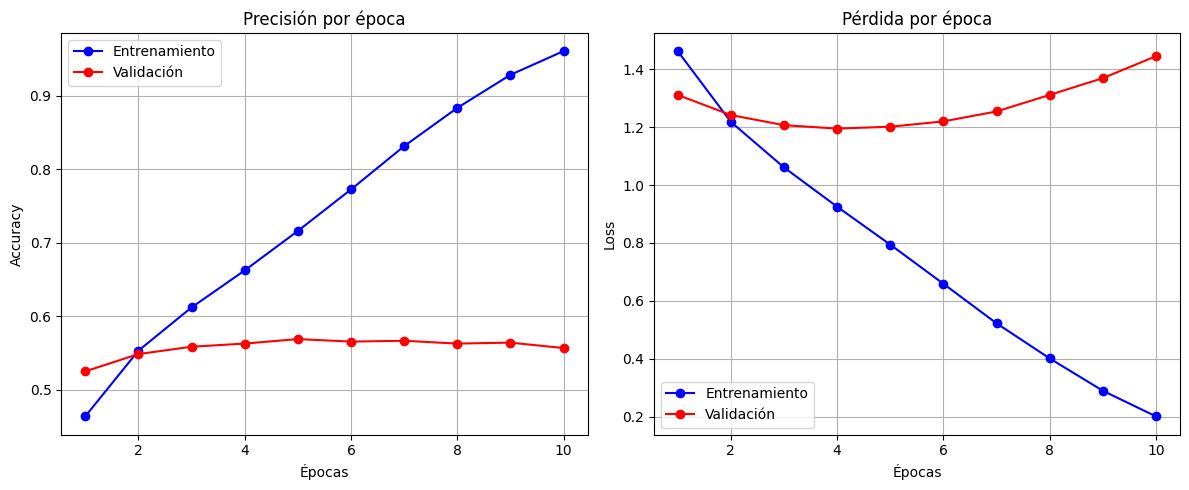

In [15]:
import matplotlib.pyplot as plt

def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Entrenamiento')
    plt.plot(epochs, val_acc, 'ro-', label='Validación')
    plt.title('Precisión por época')
    plt.xlabel('Épocas')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Entrenamiento')
    plt.plot(epochs, val_loss, 'ro-', label='Validación')
    plt.title('Pérdida por época')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Ejemplo de uso
plot_training(history_fine)

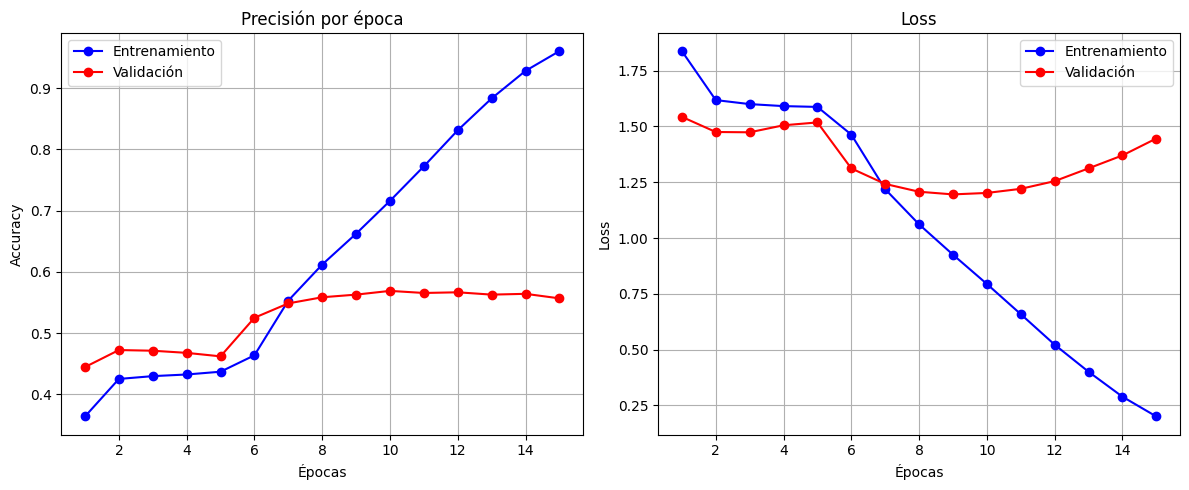

In [11]:
import numpy as np

combined_history = {
    "accuracy": np.concatenate([history.history['accuracy'], history_fine.history['accuracy']]),
    "val_accuracy": np.concatenate([history.history['val_accuracy'], history_fine.history['val_accuracy']]),
    "loss": np.concatenate([history.history['loss'], history_fine.history['loss']]),
    "val_loss": np.concatenate([history.history['val_loss'], history_fine.history['val_loss']])
}

plot_training(type('h', (), {'history': combined_history})())


In [14]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        20,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,472,832 (196.35 MB)

 Trainable params: 14,824,778 (56.55 MB)

 Non-trainable params: 6,998,496 (26.70 MB)

 Optimizer params: 29,649,558 (113.10 MB)